# Data preprocessing

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import requests

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
from tiingo import TiingoClient

config = {}

# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True

# If you don't have your API key as an environment variable,
# pass it in via a configuration dictionary.
config['api_key'] = "fd7689ea0019b4292b78d3efd6f7bb9c896083ff"

# Initialize
client = TiingoClient(config)

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [4]:
data_processor = class_DataProcessor.DataProcessor()

# Preprocessing ETFs Dataset

We proceed to retrieve the time series from the identified ETFs, and save the data retrieved in a Datframe.

1. Upload time series corresponding to ETFs and store them in a dictionary
2. Convert the dictionary in a Dataframe by concatenating time series
3. Interpolate Nan values
4. Save Dataframe in pickle file


In [5]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [6]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
224,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$105.42M,0.18%,NaN,Commodities: Precious Metals Gold
335,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$105.42M,0.18%,NaN,Commodities: Precious Metals Gold
56,Commodities,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$105.42M,0.18%,NaN,Commodities: Precious Metals Gold
359,Silver,AGQ,ProShares Ultra Silver,ProShares,$172.80M,5.28%,NaN,Leveraged Commodities: Precious Metals Silver
331,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$172.80M,5.28%,NaN,Leveraged Commodities: Precious Metals Silver
46,Commodities,AGQ,ProShares Ultra Silver,ProShares,$172.80M,5.28%,NaN,Leveraged Commodities: Precious Metals Silver
141,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.60M,0.45%,3.64%,Commodities: Agriculture Cotton
102,Commodities,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.60M,0.45%,3.64%,Commodities: Agriculture Cotton
10,Agriculture,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.60M,0.45%,3.64%,Commodities: Agriculture Cotton
326,Precious Metals,BAR,GraniteShares Gold Trust,GraniteShares,$444.96M,0.17%,NaN,Commodities: Precious Metals Gold


In [7]:
etfs_unique.Segment.value_counts()

Equity: U.S. MLPs                                            25
Commodities: Broad Market                                    21
Commodities: Precious Metals Gold                            12
Equity: U.S. Energy                                          11
Commodities: Energy Crude Oil                                 9
Equity: Global Gold Miners                                    7
Inverse Commodities: Energy Crude Oil                         6
Commodities: Agriculture                                      6
Commodities: Precious Metals Silver                           5
Equity: Global Metals & Mining                                5
Equity: Global Water                                          5
Leveraged Commodities: Energy Crude Oil                       5
Commodities: Energy                                           4
Inverse Commodities: Precious Metals Gold                     4
Equity: U.S. Oil & Gas Equipment & Services                   3
Inverse Equity: Global Gold Miners      

In [8]:
print('There are a total of {} segments'.format(len(etfs_unique.Segment.value_counts())))

There are a total of 65 segments


**Save a dictionary with ticker and corresponding segment**

In [15]:
ticker_segment_dict = pd.Series(etfs_unique.Segment.values,index=etfs_unique.Ticker).to_dict()
with open('data/etfs/pickle/ticker_segment_dict.pickle', 'wb') as handle:
    pickle.dump(ticker_segment_dict, handle)

**Let's see how this dataset compares with the one proposed when we select solely the commodity ETFs**

In [43]:
etfs_small, etfs_unique_small, tickers_small = \
                data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs.xlsx')

In [44]:
not_overlappping = pd.Series()
for sample in etfs_unique.Ticker:
    if sample not in etfs_small.Ticker.values:
        not_overlappping = pd.concat([not_overlappping, etfs_unique[etfs_unique.Ticker == sample].Segment])

In [ ]:
not_overlappping.value_counts()

In [ ]:
print(len(not_overlappping))
print(len(etfs_unique)-len(etfs_small))

The broader category contains ETFs that are not directly investing in commodities but in related companies instead. These look like a good investment opportunity and therefore we will guide ourselves through the broader group. We will discard those that are not possible to retrieve.

As for downloading the data, we define a wide interval, from 2000 to 2019. Those ETFs not trading during the entire interval will automatically fill with np.Nan the non-trading days.

**1) Download prices**

*ALERT: DO NOT RUN, UPLOAD PICKLE FILE*

In [61]:
tickers = list(tickers)
frequency = 'daily'

In [62]:
error_counter = 0
dataset_tiingo = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = client.get_dataframe([ticker],
                                  frequency=frequency,
                                  metric_name='adjClose',
                                  startDate='2000-01-01',
                                  endDate='2019-01-01')
        series = df[ticker]
        series.name = ticker  # filter close price only
        dataset_tiingo[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for ' + ticker)

print('\nUnable to download ' + str(error_counter / len(tickers) * 100) + '% of the ETFs')

df_prices, _ = data_processor.dict_to_df(dataset_tiingo)

# We try to fill sporadic null values. For this purpose we can use either the `interpolate` or the
# `fillna` function.
# src: https://datascience.stackexchange.com/questions/25924/difference-between-interpolate-and-fillna-in-pandas.
# Using the limit parameter, we can set the maximum number of consecutive NaNs to fill.

limit = 5
df_prices_interpolate = df_prices.interpolate(method="linear",limit=limit)
df_prices_interpolate.to_pickle('data/etfs/pickle/commodity_ETFs_interpolated')

Not Possible to retrieve information for NRGD
Not Possible to retrieve information for NRGO
Not Possible to retrieve information for NRGU
Not Possible to retrieve information for NRGZ
Not Possible to retrieve information for YGRN

Unable to download 2.3474178403755865% of the ETFs


**2) Download volume data**

*ALERT: DO NOT RUN, UPLOAD PICKLE FILE*

In [83]:
# get info about volume
frequency = 'daily'
error_counter = 0
dataset_tiingo_volume = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = client.get_dataframe([ticker],
                                  frequency=frequency,
                                  metric_name='volume',
                                  startDate='2000-01-01',
                                  endDate='2019-01-01')
        series = df[ticker]
        series.name = ticker  # filter close price only
        dataset_tiingo_volume[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for ' + ticker)

print('\nUnable to download info about volume from ' + str(error_counter / len(tickers) * 100) + '% of the ETFs')

df_volume, _ = data_processor.dict_to_df(dataset_tiingo_volume)

# interpolate
limit = 5
df_volume = df_volume.interpolate(method="linear",limit=limit)
df_volume.to_pickle('data/etfs/pickle/commodity_ETFs_volume')

Not Possible to retrieve information for NRGD
Not Possible to retrieve information for NRGO
Not Possible to retrieve information for NRGU
Not Possible to retrieve information for NRGZ
Not Possible to retrieve information for YGRN

Unable to download info about volume from 2.3474178403755865% of the ETFs


# Data cleaning - starts here

**Define dates**

In [9]:
initial_train_date = '01-01-2009'
final_train_date = '31-12-2017'
initial_test_date = '01-01-2018'
final_test_date = '31-12-2018'

**3)Filter ETFs with at least one day of no trading**

In [80]:
# in case you need to read the previously saved df
df_volume = pd.read_pickle('data/etfs/pickle/commodity_ETFs_volume')

# split data in training and test
df_volume_train, df_volume_test = data_processor.split_data(df_volume,
                                                            (initial_train_date,
                                                             final_train_date),
                                                            (initial_test_date,
                                                             final_test_date),
                                                            remove_nan=True)

# interpolate for single day ocurrences
df_volume_train = df_volume_train.replace(to_replace=0,value=np.nan)
df_volume_train = df_volume_train.interpolate(method="linear",limit=2)
# replace again by zeros
df_volume_train = df_volume_train.replace(to_replace=np.nan,value=0)

non_zeros_counts = df_volume_train.fillna(0).astype(bool).sum(axis=0)
zero_counts = pd.Series([len(df_volume_train)]*len(non_zeros_counts), index=non_zeros_counts.index) -\
              non_zeros_counts
zero_counts = zero_counts[zero_counts != 0]
    
print('Must remove {} tickers because of insufficient liquidity'.format(len(zero_counts)))
tickers_to_remove = list(zero_counts.index)

# filter prices 
df_prices_interday = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated')
df_prices_interday_screened = df_prices_interday.drop(columns=tickers_to_remove)
df_prices_interday_screened.to_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

Total of 208 tickers
Total of 71 tickers after removing tickers with Nan values
Must remove 12 tickers because of insufficient liquidity


**4) Analyzing data set feasibiity**

In [82]:
# in case you need to read the previously saved df
df_prices_interday = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [83]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices_interday,
                                                            (initial_train_date,
                                                             final_train_date),
                                                            (initial_test_date,
                                                             final_test_date),
                                                            remove_nan=True)
print('Total days of trading: ', len(df_prices_train)+len(df_prices_test))

Total of 196 tickers
Total of 59 tickers after removing tickers with Nan values
Total days of trading:  2516


Naturally, only ETFs available to trade at the present time can be obtained.

**5) List of ETFs**

In [84]:
etfs_list = list(df_prices_train.columns)
with open('data/etfs/ETFs.txt', 'w') as f:
    for item in etfs_list:
        f.write("%s\n" % item)

# Intraday data

In [85]:
len(tickers_to_remove)

12

In [189]:
df_prices = pd.read_excel('data/etfs/intraday_etfs.xlsx')
df_prices.index = pd.to_datetime(df_prices.index)

# interpolate
limit = 5
df_prices_interpolate = df_prices.interpolate(method="linear",limit=limit)

# screen iliquid ETFs
df_prices_screened = df_prices_interpolate.drop(columns=tickers_to_remove)
df_prices_screened.to_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened')

In [190]:
df_prices_screened.tail(3)

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DGL,...,UGA,UGL,UNG,USL,USO,VDE,XES,XLE,XME,XOP
2018-12-31 20:50:00,26.447,31.080,16.930,15.38,14.5,12.45,8.474,36.35,22.982,39.51,...,22.92,37.375,24.690,17.97,9.674,76.846,8.96,57.13,26.140,26.445
2018-12-31 20:55:00,26.410,31.078,16.930,15.37,14.5,12.45,8.470,36.35,22.982,39.51,...,22.95,37.380,24.695,17.97,9.670,76.670,8.94,56.99,26.065,26.375
2018-12-31 21:00:00,26.370,31.140,16.945,15.39,14.5,12.41,8.460,36.35,22.980,39.51,...,22.95,37.400,24.710,17.95,9.670,77.090,9.00,57.35,26.190,26.530


**Remove outliers by hand**

In [191]:
def outliers(df_real):
    df = df_real.copy()
    
    outliers = []
    for ticker in df.columns:
        outliers_idx = df[ticker][np.abs(df[ticker].pct_change()) > 0.5].index
        if len(outliers_idx)>0:
            outliers.append((ticker, outliers_idx))
        #df[ticker][outliers_idx] = np.nan
        #limit = 2
        #df[ticker] = df[ticker].fillna(method='ffill', limit=limit)
        
    #df = data_processor.remove_tickers_with_nan(df, 0)
        
    return outliers

In [192]:
price_outliers = outliers(df_prices_screened)

Correct:

In [193]:
price_outliers

[('NLR',
  DatetimeIndex(['2013-07-01 13:35:00', '2013-07-01 13:55:00'], dtype='datetime64[ns]', freq=None)),
 ('PXI', DatetimeIndex(['2010-05-06 18:50:00', '2010-05-06 19:00:00',
                 '2010-05-06 19:05:00'],
                dtype='datetime64[ns]', freq=None)),
 ('RYE',
  DatetimeIndex(['2010-05-06 18:55:00', '2010-05-06 19:00:00'], dtype='datetime64[ns]', freq=None))]

In [194]:
# detected using function above
df_prices_screened['NLR']['2013-07-01 13:35:00':'2013-07-01 13:50:00']= 35.881
df_prices_screened['PXI']['2010-05-06 18:50:00':'2010-05-06 19:00:00']= 24.75800
df_prices_screened['RYE']['2010-05-06 18:55:00']=40.808
# detected by analyzing pair results
#df_prices_screened['FXN']['2010-05-06 19:00:00']=15.589
#df_prices_screened['IYE']['2010-05-06 18:55:00']=26.684
#df_prices_screened['GLL']['2009-01-23 17:50:00':'2009-01-23 18:00:00']=359.00
df_prices_screened.to_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers')

Comparing intra day with interday data:

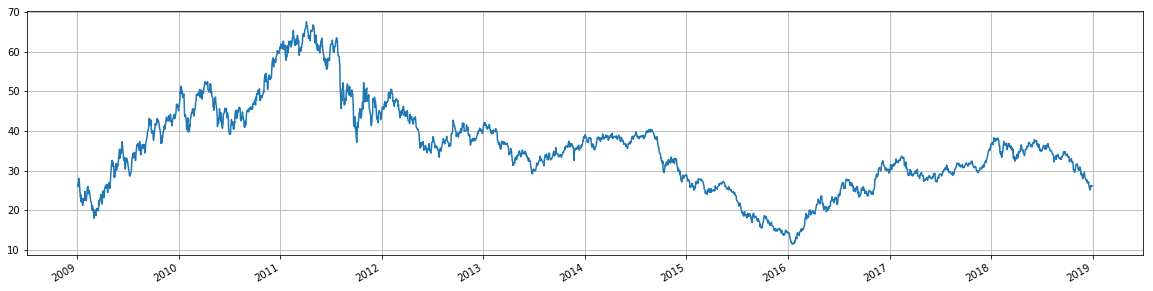

In [92]:
df_prices_interday['XME']['2009-01-01':].plot(figsize=(20,5),grid=True)

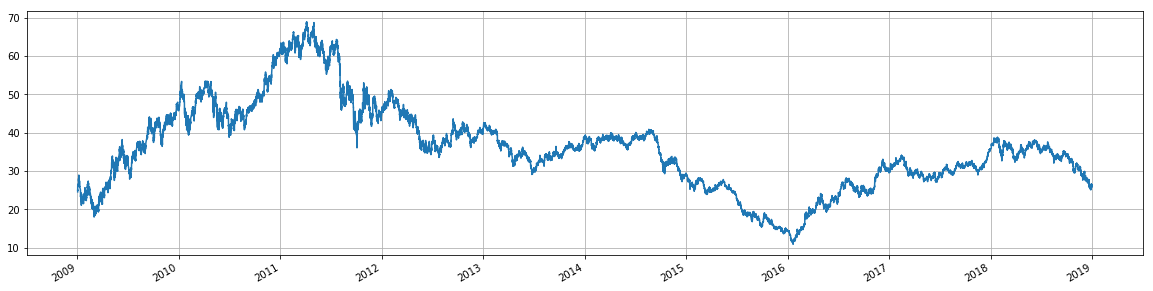

In [93]:
df_prices['XME'].plot(figsize=(20,5),grid=True)